In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import yfinance as yf
import sys
sys.path.append('/Users/kailiu/StockMarketPrediction-') 
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)


### single parameter model

In [49]:
df = yf.download('AAPL', start='2010-01-01', end='2023-12-31')[['Close']]

df_multiple = df.copy()


print(df.head())

[*********************100%***********************]  1 of 1 completed

Price          Close
Ticker          AAPL
Date                
2010-01-04  7.643214
2010-01-05  7.656429
2010-01-06  7.534643
2010-01-07  7.520714
2010-01-08  7.570714


In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
# Assuming 'df' is your DataFrame with a 'Close' column
# Create lag features for the last 10 days
n_lags = 10
for lag in range(1, n_lags + 1):
    df[f'Lag_{lag}'] = df['Close'].shift(lag)

df['target'] = df['Close'].shift(-1)
# Drop rows with NaN values (due to lagging)
df.dropna(inplace=True)

# Prepare the dataset
X = df[[f'Lag_{lag}' for lag in range(1, n_lags + 1)]]
y = df['target']



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Predict the next day's value using the last 10 days of data
last_10_days = df['Close'].iloc[-n_lags:].values.reshape(1, -1)
next_day_prediction = model.predict(last_10_days)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')




Mean Squared Error: 14.34
R-squared: 0.96
Mean Absolute Error: 2.93


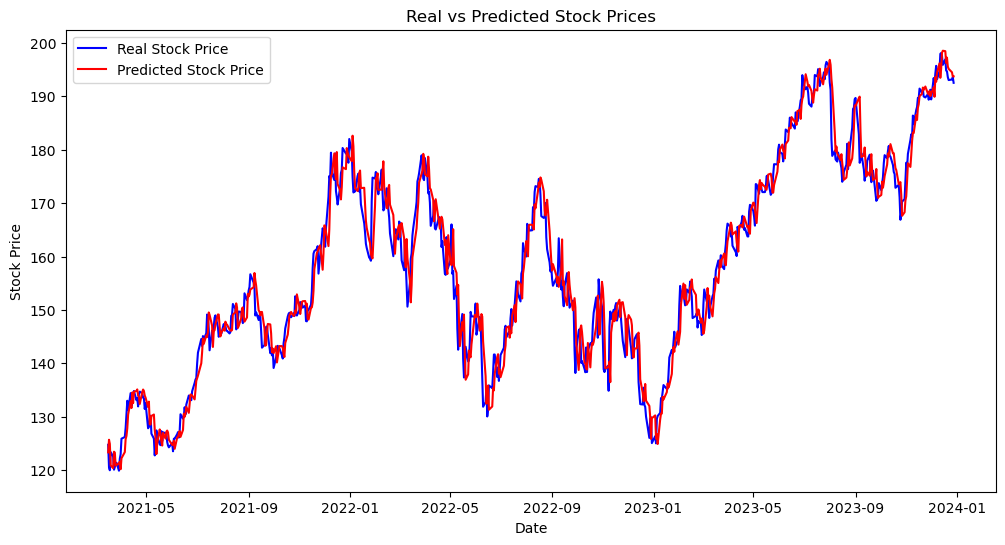

In [5]:
# Flatten y_pred to make it 1-dimensional
y_pred_flat = y_pred.flatten()

# Ensure y_pred is a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred_flat, index=y_test.index)

# Plot the real and predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real Stock Price', color='blue')
plt.plot(y_pred_series, label='Predicted Stock Price', color='red')
plt.legend()
plt.title('Real vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


### multiple parameter model

In [50]:
# calculate macd
from utils.fianacialtools import calculate_macd, generate_signals




df_multiple['EMA'] = df_multiple['Close'].ewm(span=10, adjust=False).mean()

df_multiple['MACD'] = calculate_macd(df_multiple)

df_multiple = generate_signals(df_multiple)

df_multiple.head()



Price,Close,EMA,MACD,RSI,Buy_Signal,Sell_Signal
Ticker,AAPL,,,,,
Date,,,,,,
2010-01-04,7.643214,7.643214,0.000000,NaN,0,0
2010-01-05,7.656429,7.645617,0.001054,100.000000,0,1
2010-01-06,7.534643,7.625440,-0.007847,9.788567,1,0
2010-01-07,7.520714,7.606399,-0.015843,8.873044,1,0
2010-01-08,7.570714,7.599911,-0.017938,31.777433,0,0


In [51]:
# set lookback days
lookback_days = 10

# create lag features
for feature in ['Close', 'EMA', 'MACD', 'RSI', 'Buy_Signal', 'Sell_Signal']:
    for lag in range(1, lookback_days + 1):
        df_multiple[f'{feature}_lag_{lag}'] = df_multiple[feature].shift(lag)


df_multiple['target'] = df_multiple['Close'].shift(-1)

df_multiple.dropna(inplace=True)

# Check for remaining NaN values
if df.isnull().values.any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been removed.")


All NaN values have been removed.


In [52]:

# prepare features and target
features = [col for col in df_multiple.columns if col not in ['Close', 'target', 'Date']]  # 确保不包含目标列和日期列
X = df_multiple[features]
y = df_multiple['target']

# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_multiple_train, X_multiple_test, y_multiple_train, y_multiple_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# train model
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.01, random_state=42)
model.fit(X_multiple_train, y_multiple_train)

# predict
y_multiple_pred = model.predict(X_multiple_test)



In [53]:
# evaluate model
multiple_mse = mean_squared_error(y_multiple_test, y_multiple_pred)
print(f'Mean Squared Error: {multiple_mse:.2f}')
multiple_mae = mean_absolute_error(y_multiple_test, y_multiple_pred)
print(f'Mean Absolute Error: {multiple_mae:.2f}')
multiple_r2 = r2_score(y_multiple_test, y_multiple_pred)
print(f'R-squared: {multiple_r2:.2f}')




Mean Squared Error: 0.68
Mean Absolute Error: 0.62
R-squared: 1.00


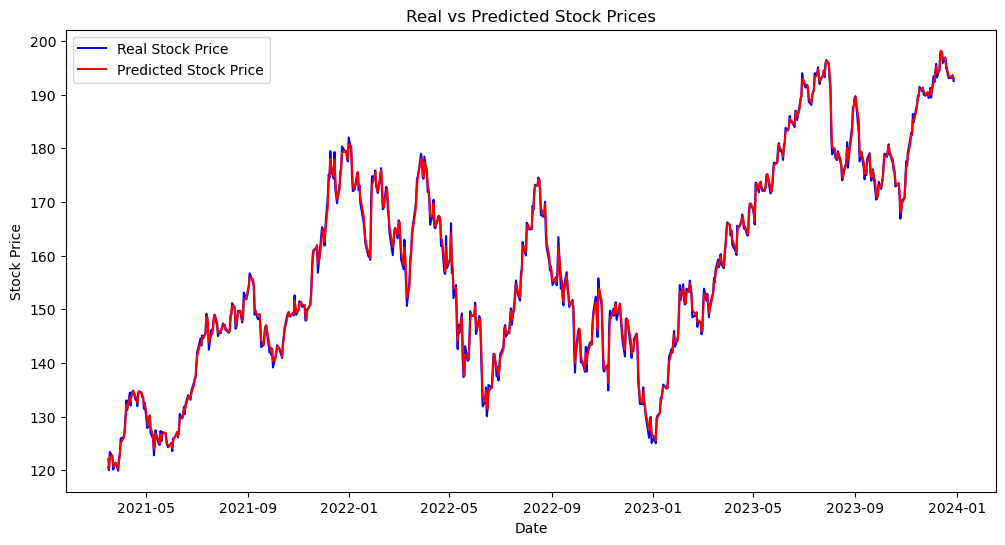

In [54]:

# Flatten y_pred to make it 1-dimensional
y_multiple_pred_flat = y_multiple_pred.flatten()

# Ensure y_pred is a pandas Series with the same index as y_test
y_multiple_pred_series = pd.Series(y_multiple_pred_flat, index=y_multiple_test.index)
# plot real vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_multiple_test, label='Real Stock Price', color='blue')
plt.plot(y_multiple_pred_series, label='Predicted Stock Price', color='red')
plt.legend()
plt.title('Real vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
